# Log
- optimization averege across different confusion matrices - that seems to have a big effect on the performance of enabling surrogate

# TODO
 - keep the confusion matrix estimation same - across all trials?
 - double check that params are getting properly propagated for the Agent and environment
 - ~~grid search for parameters~~
 - figure out parameters in surrogate rewards
 - ~~make rewards non binary in environment and surrogate rewards~~
 - ~~add deceay from papers, log and other~~
 - initiate q-table at `-1`?
 - run experiment with different `correct_action`
 - should we be setting up the glove for `very distinguishable` levels? Shouldn't we set it up with `barely distinguishable` levels, as this is where the perturbed rewards come on - they'd help us get through the noise and find the correct level.

# Scripts

In [1]:
import numpy as np
import collections
import pandas as pd
import argparse
import time
import numpy as np

In [2]:
import noise_estimator

In [3]:
# from ucbq_agent import UCBQAgent
from ucbq_agent_stateless import UCBQAgent
# from ucbq_environment import ModifiedRandomEnvironment
from ucbq_environment_stateless import ModifiedRandomEnvironment

# Params

In [4]:
max_steps = 120
num_episodes = 100
num_actions = 7
# start_state = 1
start_action = 0
# zero indexed
correct_action = 1

# Scripts

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import utils

In [6]:
def get_mean_across_episodes(arr):
    min_cols = np.amin([len(row) for row in arr])
    truncated_arr = [ x[:min_cols] for x in arr ]
    res = np.array(truncated_arr)
    mean = res.mean(axis=0)

    return mean    

def get_cumsum_rewards(rewards):
    cumulative_sum_rewards = np.cumsum(rewards)
    time_steps = np.arange(1, len(rewards) + 1)
    mean_rewards = cumulative_sum_rewards / time_steps
    return mean_rewards

In [7]:
from modified_pendulum_processor import ModifiedPendulumProcessor

In [8]:
def runner(adjust_rewards=None, 
           agent=None,
           env=None,
           params={}):

    agent = UCBQAgent(params=params) if agent is None else agent
    env = env if env else ModifiedRandomEnvironment()

    episode_rewards = 0
    rewards = []
    q_values_for_chart = []
    
    t = 0
    action = start_action
    state = 0
    plots = params.get('plots', True)
    noise = params.get('noise', False)
    surrogate = params.get('surrogate', False)
    surrogate_c_interval = params.get('surrogate_c_interval', 10)
    
    reward_processor = None

    # surrogate can only be with noise=True for now
    if surrogate:
        noise = True
    
    if noise: 
        #TODO: should we keep/carry over the estimated confusion matrix across all episodes?
        # num_unique_rewards = correct_action + 1
        num_unique_rewards = utils.get_num_unique_rewards(num_actions, correct_action)
        reward_processor = ModifiedPendulumProcessor(surrogate=surrogate, surrogate_c_interval=surrogate_c_interval, num_unique_rewards=num_unique_rewards)

    while True:
        if t == max_steps - 1:
            break

        action = agent.choose_action(state) 
        reward, next_state, done = env.step(action)        
        
        if done:
            break     

        rewards.append(reward)

        if noise or surrogate:
            observation, reward, done, info = reward_processor.process_step(state, reward, None, None, action)
        
        agent.learn(state, action, reward, next_state)
        episode_rewards += reward
        t += 1

        if plots:
            if t % 10 == 0:
                sum_q_values_across_states = np.around(np.sum(agent.Q, axis=0), decimals=4)
                q_values_for_chart.append(sum_q_values_across_states)
      
                
    episode_length = t + 1
    selected_action = action 
    
    if t == max_steps - 1:
        # If we reached the end of the episode
        # select the action with the highest Q-values as the correct one
        sum_q_values_across_states = np.sum(agent.Q, axis=0)
        selected_action = np.argmax(sum_q_values_across_states)

    return q_values_for_chart, rewards, episode_length, selected_action, reward_processor

In [9]:
def qLearningExperiment(learner=None, params={}):
    plots = params.get('plots', True)

    q_values_all_experiments = []
    rewards_all_experiments = []
    episode_lengths = []
    selected_actions = []

    for i in tqdm(range(num_episodes)):
        # TODO: .reset() instead of re-creating?
        agent = UCBQAgent(params=params) if learner is None else learner
        env = ModifiedRandomEnvironment(correct_action=correct_action)
        q_values_for_chart, rewards, episode_length, selected_action, reward_processor = runner(env=env, agent=agent, params=params)
        selected_actions.append(selected_action)
        episode_lengths.append(episode_length)
                
        rewards_all_experiments.append(rewards)
        q_values_all_experiments.append(q_values_for_chart)

    correct_count = selected_actions.count(correct_action)
    accuracy = (correct_count / len(selected_actions)) * 100
    
    return q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, reward_processor


In [10]:
def plot_mean_q_values(params={}):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, last_reward_processor = qLearningExperiment(params=params)
    print(f'Accuracy: {accuracy}')    
    print(f'Mean episode length: {np.mean(episode_lengths)}')

    all_mean_rewards = [ get_cumsum_rewards(rewards) for rewards in rewards_all_experiments ]

    all_mean_rewards = pd.DataFrame(all_mean_rewards) # rewards have different lengths
    # because they terminate earlier sometimes
    mean_matrix = np.mean(all_mean_rewards, axis=0)
    mean_rewards_across_episodes = pd.DataFrame(mean_matrix)

    mean_matrix = get_mean_across_episodes(q_values_all_experiments)
    mean_q_values_across_episodes = pd.DataFrame(mean_matrix)
    if params.get('noise', False): 
        print('Last reward processor:')
        last_reward_processor.print()

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    mean_rewards_across_episodes.plot(ax=axes[0, 0], title='Mean reward for this step across all episodes')
    mean_q_values_across_episodes.plot(ax=axes[0, 1], title='Mean Q-values accross all episodes')
    pd.DataFrame(episode_lengths).plot(ax=axes[1, 0], title='Episode lengths', marker='*')
    pd.DataFrame(selected_actions).plot(ax=axes[1, 1], title='Guessed correct action per episode', marker='*')
    plt.tight_layout()
    plt.show()

# Params

In [11]:
def default_params():
    """ These are the default parameters used in the framework. """
    return {
            # # Runner parameters
            # 'max_episodes': int(1E6),         # experiment stops after this many episodes
            # 'max_steps': int(1E9),            # experiment stops after this many steps
            # 'multi_runner': False,            # uses multiple runners if True
            # Optimization parameters
            'alpha': 0.5,                       # learning rate of optimizer
            'alpha_decay': 40,
            'alpha_min': 0.001,
            # Exploration parameters
            'epsilon': 1,               # annealing starts at this epsilon
            'epsilon_decay': 20,
            'epsilon_min': 0.01,    
            'gamma': 0.95,                    # discount factor gamma
            'plots': False,
            'noise': True,
            'surrogate': False,            
           }

# Real rewards UCB Q-learning

In [12]:
params = default_params()
params['noise'] = False

agent = UCBQAgent()

runner(agent=agent)
utils.print_agent_stats(agent)

Q-table:
[[-8 -9 -7 -7 -6 -6  0]]
Number of times action was taken:
[[ 2.  5.  2.  2.  3.  4. 38.]]
Total timesteps:
50


100%|██████████| 100/100 [00:00<00:00, 584.04it/s]


Accuracy: 100.0
Mean episode length: 50.0


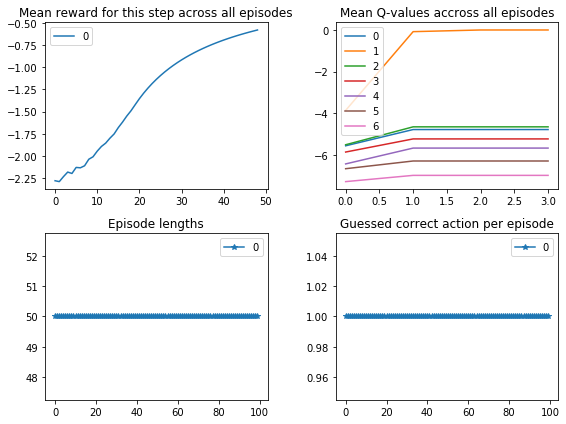

In [18]:
params = default_params()
params['noise'] = False
params['plots'] = True

# The Q-value shape make sense - we're trying higher numbers later
# so they converge to -1 slower than e.g. action 0 or 1
plot_mean_q_values()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

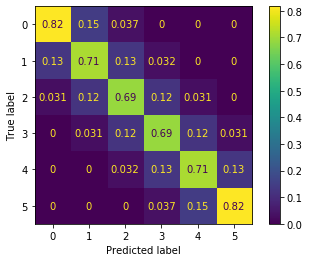

True

In [15]:
# Confusion matrix used as noise
num_unique_rewards = utils.get_num_unique_rewards(num_actions=num_actions, correct_action=correct_action)
cmat = ModifiedPendulumProcessor(num_unique_rewards=num_unique_rewards).initialize_cmat(diag=0.69)
ConfusionMatrixDisplay(confusion_matrix=cmat).plot()
plt.show()
noise_estimator.is_invertible(cmat)

100%|██████████| 100/100 [00:00<00:00, 296.27it/s]


Accuracy: 84.0
Mean episode length: 50.29
Last reward processor:
Estimated confusion matrix:


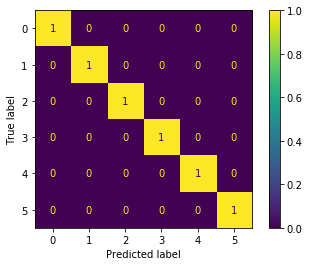

Reward sets:
{(0, 2): [-1, 0], (0, 1): [-1, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, -1, -1, 0, 0, 0, 0, -2, 0, 0, 0, -1, 0, 0, 0, -2, 0, -1, -1, 0, 0, 0], (0, 4): [-3, -2], (0, 0): [-2, -1, 0, -1], (0, 6): [-5, -4], (0, 3): [-2, -1], (0, 5): [-3]}
Reward set counts:
Key (0, 2): 2 items
Key (0, 1): 36 items
Key (0, 4): 2 items
Key (0, 0): 4 items
Key (0, 6): 2 items
Key (0, 3): 2 items
Key (0, 5): 1 items


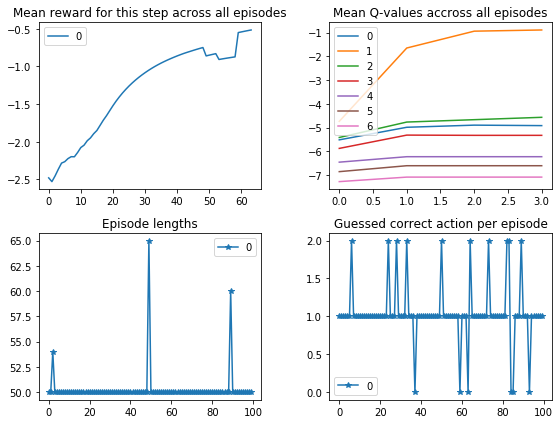

In [19]:
# res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
# params=res['params']
params = default_params()
params['plots'] = True
plot_mean_q_values(params=params)

# Surrogate rewards

100%|██████████| 100/100 [00:00<00:00, 432.66it/s]


Accuracy: 85.0
Mean episode length: 50.07
Last reward processor:
Estimated confusion matrix:


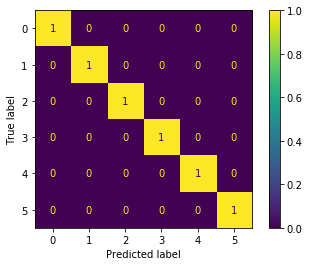

Reward sets:
{(0, 4): [-4, -3], (0, 5): [-4, -4], (0, 0): [-1, -1, 0, 0, -1, -3, 0, -3, -2, -1, 0, -1, -1, -3, 0, -1, -1, -1, -2, -1, -1, 0, -1, -2, -2, 0, 0, -1, 0, -1, -3, -2, -1, -2, -1, -1], (0, 6): [-4, -5, -5], (0, 3): [-2, -2], (0, 2): [-1, -2], (0, 1): [-2, -2]}
Reward set counts:
Key (0, 4): 2 items
Key (0, 5): 2 items
Key (0, 0): 36 items
Key (0, 6): 3 items
Key (0, 3): 2 items
Key (0, 2): 2 items
Key (0, 1): 2 items


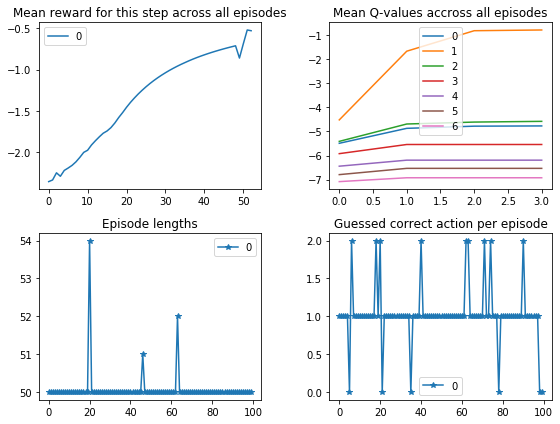

In [22]:
params_new ={'noise': True, 'surrogate': True, 'plots': True, 'surrogate_c_interval': 20}
params = default_params() | params
plot_mean_q_values(params = params)

# Sanity check

In [19]:
max_steps = 120
num_episodes = 100

params = {
    # # Runner parameters
    # 'max_episodes': int(1E6),         # experiment stops after this many episodes
    # 'max_steps': int(1E9),            # experiment stops after this many steps
    # 'multi_runner': False,            # uses multiple runners if True
    # Optimization parameters
    'alpha': 0.5,                       # learning rate of optimizer
    'alpha_decay': 40,
    'alpha_min': 0.001,
    # Exploration parameters
    'epsilon': 1,               # annealing starts at this epsilon
    'epsilon_decay': 20,
    'epsilon_min': 0.01,    
    'gamma': 0.95,                    # discount factor gamma
    'plots': False,
}

print('Accuracy should be higher, timesteps should be lower')

params['noise'] = False
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = True
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

Accuracy should be higher, timesteps should be lower


100%|██████████| 100/100 [00:00<00:00, 983.15it/s]


100.0 50.0


100%|██████████| 100/100 [00:00<00:00, 734.43it/s]


83.0 50.26


100%|██████████| 100/100 [00:00<00:00, 535.92it/s]

84.0 50.3


# Bayesian optimization

In [21]:
# | 24        | 100.0     | 0.9026    | 826.9     | 0.0       | 73.21     |
# this with noise True and surrogate False
# no alpha decay
# | 184       | 99.0      | 0.8236    | 243.1     | 0.5114    | 0.2529    | 70.53     | 0.04431   | 0.8871    | 67.76     |

In [ ]:
from bayes_opt import BayesianOptimization

In [25]:
max_steps = 120
num_episodes = 1000

def objective(
        alpha,
        # alpha_decay,
        alpha_min,
        epsilon,
        epsilon_decay,
        epsilon_min,
        gamma,
        # surrogate_c_interval,
        ):
    # # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # # 'surrogate_lr'    
    # convergence_number_of_consequent_actions
    # intial_q_values: [0, -7]

    # surrogate_c_interval = int(surrogate_c_interval)

    new_params = {
        'alpha': alpha, 
        # 'alpha_decay': alpha_decay,
        'alpha_min': alpha_min,
        'epsilon': epsilon, 
        'epsilon_decay': epsilon_decay,
        'epsilon_min': epsilon_min,
        'gamma': gamma,
        # 'plots': False,   
        # 'surrogate_c_interval': surrogate_c_interval,
        #
        'noise': True,
        'surrogate': False,
        # 'diag': 0.9     
    }

    params = default_params() | new_params

    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
    


    # params['surrogate'] = False
    # q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy_no_surrogate, _ = qLearningExperiment(params=params)


    # accuracy = accuracy_surrogate - accuracy_no_surrogate
    
    # mean_episode_length = np.mean(episode_lengths)
    # return -mean_episode_length
    return accuracy

optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'alpha': (0, 1), 
        # 'alpha_decay': (1, 1000),
        'alpha_min': (0, 1),
        'epsilon': (0, 1), 
        'epsilon_decay': (10, 80),
        'epsilon_min': (0, 1),
        'gamma': (0, 1),
        # 'surrogate_c_interval': (1, 120)
        },
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. 
# The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

best_params = optimizer.max['params']

print(optimizer.max)

|   iter    |  target   |   alpha   | alpha_min |  epsilon  | epsilo... | epsilo... |   gamma   |
-------------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [00:02<00:00, 496.24it/s]


| 1         | 0.0       | 0.417     | 0.7203    | 0.0001144 | 31.16     | 0.1468    | 0.09234   |


100%|██████████| 1000/1000 [00:04<00:00, 214.37it/s]


| 2         | 27.2      | 0.1863    | 0.3456    | 0.3968    | 47.72     | 0.4192    | 0.6852    |


100%|██████████| 1000/1000 [00:02<00:00, 489.08it/s]


| 3         | 6.4       | 0.2045    | 0.8781    | 0.02739   | 56.93     | 0.4173    | 0.5587    |


100%|██████████| 1000/1000 [00:04<00:00, 223.69it/s]


| 4         | 41.9      | 0.1404    | 0.1981    | 0.8007    | 77.78     | 0.3134    | 0.6923    |


100%|██████████| 1000/1000 [00:02<00:00, 358.70it/s]


| 5         | 92.9      | 0.8764    | 0.8946    | 0.08504   | 12.73     | 0.1698    | 0.8781    |


100%|██████████| 1000/1000 [00:04<00:00, 211.01it/s]


| 6         | 20.2      | 0.09835   | 0.4211    | 0.9579    | 47.32     | 0.6919    | 0.3155    |


100%|██████████| 1000/1000 [00:02<00:00, 483.96it/s]


| 7         | 61.3      | 0.6865    | 0.8346    | 0.01829   | 62.51     | 0.9889    | 0.7482    |


100%|██████████| 1000/1000 [00:02<00:00, 377.90it/s]


| 8         | 7.8       | 0.2804    | 0.7893    | 0.1032    | 41.35     | 0.9086    | 0.2936    |


100%|██████████| 1000/1000 [00:01<00:00, 503.32it/s]


| 9         | 0.7       | 0.2878    | 0.13      | 0.01937   | 57.52     | 0.2116    | 0.2655    |


100%|██████████| 1000/1000 [00:04<00:00, 211.29it/s]


| 10        | 53.6      | 0.4916    | 0.05336   | 0.5741    | 20.27     | 0.5893    | 0.6998    |


100%|██████████| 1000/1000 [00:02<00:00, 443.11it/s]


| 11        | 20.8      | 0.1023    | 0.4141    | 0.6944    | 38.99     | 0.04995   | 0.5359    |


100%|██████████| 1000/1000 [00:04<00:00, 212.03it/s]


| 12        | 56.5      | 0.6638    | 0.5149    | 0.9446    | 51.06     | 0.9034    | 0.1375    |


100%|██████████| 1000/1000 [00:04<00:00, 216.35it/s]


| 13        | 14.5      | 0.1393    | 0.8074    | 0.3977    | 21.57     | 0.9275    | 0.3478    |


100%|██████████| 1000/1000 [00:05<00:00, 193.00it/s]


| 14        | 61.2      | 0.7508    | 0.726     | 0.8833    | 53.66     | 0.7509    | 0.3489    |


100%|██████████| 1000/1000 [00:04<00:00, 211.03it/s]


| 15        | 19.5      | 0.2699    | 0.8959    | 0.4281    | 77.54     | 0.6634    | 0.6217    |


100%|██████████| 1000/1000 [00:03<00:00, 252.81it/s]


| 16        | 16.5      | 0.1147    | 0.9495    | 0.4499    | 50.49     | 0.4081    | 0.237     |


100%|██████████| 1000/1000 [00:01<00:00, 817.79it/s]


| 17        | 11.7      | 0.9034    | 0.5737    | 0.00287   | 53.2      | 0.3266    | 0.5271    |


100%|██████████| 1000/1000 [00:01<00:00, 664.44it/s]


| 18        | 95.0      | 0.8859    | 0.3573    | 0.9085    | 53.64     | 0.01582   | 0.9294    |


100%|██████████| 1000/1000 [00:02<00:00, 415.13it/s]


| 19        | 76.1      | 0.6909    | 0.9973    | 0.1723    | 19.6      | 0.9326    | 0.6968    |


100%|██████████| 1000/1000 [00:02<00:00, 334.06it/s]


| 20        | 16.3      | 0.066     | 0.7555    | 0.7539    | 74.61     | 0.7115    | 0.1243    |


100%|██████████| 1000/1000 [00:01<00:00, 782.30it/s]


| 21        | 6.1       | 0.01988   | 0.02621   | 0.02831   | 27.23     | 0.86      | 0.5388    |


100%|██████████| 1000/1000 [00:01<00:00, 514.58it/s]


| 22        | 91.6      | 0.5528    | 0.842     | 0.1242    | 29.54     | 0.5858    | 0.9696    |


100%|██████████| 1000/1000 [00:02<00:00, 339.17it/s]


| 23        | 61.6      | 0.561     | 0.01865   | 0.8006    | 26.31     | 0.8071    | 0.3879    |


100%|██████████| 1000/1000 [00:01<00:00, 569.23it/s]


| 24        | 58.9      | 0.8635    | 0.7471    | 0.5562    | 19.55     | 0.05992   | 0.1213    |


100%|██████████| 1000/1000 [00:02<00:00, 410.62it/s]


| 25        | 6.9       | 0.04455   | 0.1075    | 0.2257    | 59.91     | 0.5597    | 0.01256   |


100%|██████████| 1000/1000 [00:02<00:00, 419.29it/s]


| 26        | 33.2      | 0.07197   | 0.9673    | 0.5681    | 24.23     | 0.2523    | 0.7438    |


100%|██████████| 1000/1000 [00:02<00:00, 388.91it/s]


| 27        | 38.8      | 0.1954    | 0.5814    | 0.97      | 69.28     | 0.2398    | 0.4938    |


100%|██████████| 1000/1000 [00:01<00:00, 722.31it/s]


| 28        | 21.7      | 0.62      | 0.829     | 0.1568    | 11.3      | 0.07002   | 0.4863    |


100%|██████████| 1000/1000 [00:02<00:00, 350.88it/s]


| 29        | 53.9      | 0.6063    | 0.5689    | 0.3174    | 79.2      | 0.5797    | 0.3801    |


100%|██████████| 1000/1000 [00:01<00:00, 679.79it/s]


| 30        | 54.3      | 0.5509    | 0.7453    | 0.6692    | 28.54     | 0.06633   | 0.3701    |


100%|██████████| 1000/1000 [00:02<00:00, 372.42it/s]


| 31        | 79.4      | 0.6297    | 0.2102    | 0.7528    | 14.66     | 0.2603    | 0.8048    |


100%|██████████| 1000/1000 [00:02<00:00, 377.60it/s]


| 32        | 28.9      | 0.1934    | 0.6395    | 0.5247    | 74.74     | 0.2633    | 0.06596   |


100%|██████████| 1000/1000 [00:01<00:00, 520.14it/s]


| 33        | 84.1      | 0.7351    | 0.7722    | 0.9078    | 75.24     | 0.01395   | 0.2344    |


100%|██████████| 1000/1000 [00:02<00:00, 337.70it/s]


| 34        | 54.3      | 0.6168    | 0.949     | 0.9502    | 48.97     | 0.9156    | 0.6416    |


100%|██████████| 1000/1000 [00:02<00:00, 337.07it/s]


| 35        | 56.1      | 0.39      | 0.486     | 0.6043    | 48.47     | 0.9262    | 0.9187    |


100%|██████████| 1000/1000 [00:01<00:00, 510.78it/s]


| 36        | 35.6      | 0.3949    | 0.9633    | 0.174     | 18.84     | 0.1351    | 0.5057    |


100%|██████████| 1000/1000 [00:01<00:00, 527.07it/s]


| 37        | 23.5      | 0.02152   | 0.948     | 0.8271    | 11.05     | 0.1762    | 0.3321    |


100%|██████████| 1000/1000 [00:02<00:00, 353.39it/s]


| 38        | 68.0      | 0.131     | 0.8095    | 0.3447    | 75.81     | 0.582     | 0.8788    |


100%|██████████| 1000/1000 [00:02<00:00, 338.05it/s]


| 39        | 67.9      | 0.8447    | 0.9054    | 0.4599    | 48.24     | 0.7986    | 0.2857    |


100%|██████████| 1000/1000 [00:01<00:00, 803.45it/s]


| 40        | 65.8      | 0.4903    | 0.5991    | 0.01553   | 51.54     | 0.4337    | 0.8074    |


100%|██████████| 1000/1000 [00:02<00:00, 338.13it/s]


| 41        | 21.9      | 0.3152    | 0.8929    | 0.5779    | 22.88     | 0.7879    | 0.612     |


100%|██████████| 1000/1000 [00:01<00:00, 753.29it/s]


| 42        | 79.8      | 0.05391   | 0.4202    | 0.6791    | 74.3      | 0.000402  | 0.9768    |


100%|██████████| 1000/1000 [00:03<00:00, 333.19it/s]


| 43        | 47.6      | 0.3766    | 0.9738    | 0.6047    | 68.02     | 0.5747    | 0.6281    |


100%|██████████| 1000/1000 [00:02<00:00, 336.41it/s]


| 44        | 18.4      | 0.2856    | 0.5868    | 0.75      | 70.08     | 0.7551    | 0.6981    |


100%|██████████| 1000/1000 [00:02<00:00, 340.08it/s]


| 45        | 70.4      | 0.8645    | 0.3227    | 0.6708    | 41.56     | 0.3821    | 0.4108    |


100%|██████████| 1000/1000 [00:02<00:00, 337.13it/s]


| 46        | 48.5      | 0.4015    | 0.3174    | 0.6219    | 40.12     | 0.9738    | 0.6778    |


100%|██████████| 1000/1000 [00:02<00:00, 355.41it/s]


| 47        | 66.8      | 0.1986    | 0.4267    | 0.3433    | 65.83     | 0.88      | 0.9038    |


100%|██████████| 1000/1000 [00:02<00:00, 359.99it/s]


| 48        | 75.1      | 0.6627    | 0.2702    | 0.2524    | 69.84     | 0.5277    | 0.8022    |


100%|██████████| 1000/1000 [00:02<00:00, 338.16it/s]


| 49        | 59.3      | 0.5725    | 0.7331    | 0.519     | 63.96     | 0.5689    | 0.4657    |


100%|██████████| 1000/1000 [00:02<00:00, 347.51it/s]


| 50        | 56.3      | 0.3427    | 0.06821   | 0.3779    | 15.57     | 0.9828    | 0.1816    |


100%|██████████| 1000/1000 [00:02<00:00, 419.52it/s]


| 51        | 80.9      | 0.8119    | 0.875     | 0.6884    | 49.86     | 0.161     | 0.4669    |


100%|██████████| 1000/1000 [00:02<00:00, 339.54it/s]


| 52        | 56.6      | 0.3452    | 0.225     | 0.5925    | 31.86     | 0.9163    | 0.9096    |


100%|██████████| 1000/1000 [00:02<00:00, 441.72it/s]


| 53        | 18.0      | 0.2571    | 0.1109    | 0.193     | 44.97     | 0.7286    | 0.2082    |


100%|██████████| 1000/1000 [00:02<00:00, 403.27it/s]


| 54        | 21.7      | 0.248     | 0.8517    | 0.4158    | 53.17     | 0.2337    | 0.102     |


100%|██████████| 1000/1000 [00:02<00:00, 457.32it/s]


| 55        | 56.4      | 0.5159    | 0.4771    | 0.1527    | 53.53     | 0.544     | 0.6541    |


100%|██████████| 1000/1000 [00:02<00:00, 410.18it/s]


| 56        | 7.0       | 0.1445    | 0.7515    | 0.222     | 46.35     | 0.7853    | 0.02233   |


100%|██████████| 1000/1000 [00:02<00:00, 340.45it/s]


| 57        | 20.9      | 0.3244    | 0.8729    | 0.8447    | 47.69     | 0.8666    | 0.9498    |


100%|██████████| 1000/1000 [00:01<00:00, 516.54it/s]


| 58        | 68.3      | 0.8264    | 0.8541    | 0.09874   | 55.59     | 0.7035    | 0.6102    |


100%|██████████| 1000/1000 [00:02<00:00, 360.32it/s]


| 59        | 77.2      | 0.7996    | 0.03457   | 0.7702    | 61.22     | 0.2597    | 0.2571    |


100%|██████████| 1000/1000 [00:02<00:00, 338.24it/s]


| 60        | 63.8      | 0.6323    | 0.3453    | 0.7966    | 41.23     | 0.7827    | 0.9905    |


100%|██████████| 1000/1000 [00:02<00:00, 337.60it/s]


| 61        | 13.1      | 0.3002    | 0.143     | 0.9013    | 47.91     | 0.9747    | 0.6366    |


100%|██████████| 1000/1000 [00:02<00:00, 347.80it/s]


| 62        | 76.9      | 0.9939    | 0.5461    | 0.5264    | 19.48     | 0.3557    | 0.02622   |


100%|██████████| 1000/1000 [00:01<00:00, 775.39it/s]


| 63        | 24.8      | 0.1604    | 0.7456    | 0.0304    | 35.66     | 0.8623    | 0.6927    |


100%|██████████| 1000/1000 [00:02<00:00, 345.83it/s]


| 64        | 59.9      | 0.6909    | 0.1886    | 0.4419    | 50.71     | 0.9898    | 0.2039    |


100%|██████████| 1000/1000 [00:01<00:00, 691.85it/s]


| 65        | 28.9      | 0.2477    | 0.2622    | 0.7502    | 41.99     | 0.05693   | 0.5085    |


100%|██████████| 1000/1000 [00:02<00:00, 371.06it/s]


| 66        | 68.9      | 0.212     | 0.7986    | 0.2973    | 11.93     | 0.5934    | 0.8438    |


100%|██████████| 1000/1000 [00:02<00:00, 343.10it/s]


| 67        | 62.5      | 0.381     | 0.7499    | 0.5111    | 47.87     | 0.9594    | 0.804     |


100%|██████████| 1000/1000 [00:02<00:00, 422.07it/s]


| 68        | 13.2      | 0.03232   | 0.7094    | 0.465     | 76.33     | 0.2214    | 0.2671    |


100%|██████████| 1000/1000 [00:01<00:00, 607.35it/s]


| 69        | 25.6      | 0.08147   | 0.4286    | 0.109     | 54.37     | 0.803     | 0.6968    |


100%|██████████| 1000/1000 [00:02<00:00, 337.81it/s]


| 70        | 63.4      | 0.7662    | 0.3425    | 0.8459    | 40.01     | 0.824     | 0.6265    |


100%|██████████| 1000/1000 [00:01<00:00, 789.61it/s]


| 71        | 0.2       | 0.1434    | 0.07839   | 0.01833   | 14.67     | 0.4586    | 0.1133    |


100%|██████████| 1000/1000 [00:02<00:00, 348.34it/s]


| 72        | 13.4      | 0.02778   | 0.7549    | 0.3949    | 62.29     | 0.4524    | 0.4501    |


100%|██████████| 1000/1000 [00:02<00:00, 341.90it/s]


| 73        | 30.9      | 0.4781    | 0.474     | 0.8032    | 38.17     | 0.9047    | 0.03706   |


100%|██████████| 1000/1000 [00:02<00:00, 342.83it/s]


| 74        | 61.7      | 0.7739    | 0.1256    | 0.6185    | 10.73     | 0.5386    | 0.003018  |


100%|██████████| 1000/1000 [00:02<00:00, 420.72it/s]


| 75        | 85.0      | 0.9512    | 0.9054    | 0.796     | 74.07     | 0.1456    | 0.1577    |


100%|██████████| 1000/1000 [00:02<00:00, 337.57it/s]


| 76        | 24.0      | 0.1876    | 0.6225    | 0.9058    | 79.3      | 0.7111    | 0.7318    |


100%|██████████| 1000/1000 [00:01<00:00, 560.28it/s]


| 77        | 94.7      | 0.9093    | 0.4009    | 0.2499    | 22.14     | 0.1195    | 0.8126    |


100%|██████████| 1000/1000 [00:03<00:00, 326.64it/s]


| 78        | 12.5      | 0.1468    | 0.2643    | 0.8191    | 31.74     | 0.9824    | 0.2666    |


100%|██████████| 1000/1000 [00:03<00:00, 312.05it/s]


| 79        | 57.3      | 0.5337    | 0.3145    | 0.9108    | 35.66     | 0.4336    | 0.5123    |


100%|██████████| 1000/1000 [00:01<00:00, 597.86it/s]


| 80        | 87.4      | 0.9389    | 0.03095   | 0.7169    | 72.37     | 0.02729   | 0.5221    |


100%|██████████| 1000/1000 [00:03<00:00, 322.02it/s]


| 81        | 25.0      | 0.326     | 0.8595    | 0.5585    | 58.32     | 0.4529    | 0.6283    |


100%|██████████| 1000/1000 [00:02<00:00, 344.62it/s]


| 82        | 45.2      | 0.2901    | 0.009349  | 0.5768    | 31.8      | 0.5173    | 0.9164    |


100%|██████████| 1000/1000 [00:02<00:00, 336.06it/s]


| 83        | 77.6      | 0.4265    | 0.2474    | 0.3713    | 75.23     | 0.9369    | 0.8443    |


100%|██████████| 1000/1000 [00:02<00:00, 477.08it/s]


| 84        | 54.5      | 0.9202    | 0.2279    | 0.08748   | 25.91     | 0.3144    | 0.1748    |


100%|██████████| 1000/1000 [00:03<00:00, 287.66it/s]


| 85        | 62.3      | 0.6071    | 0.4136    | 0.8164    | 22.96     | 0.7019    | 0.2404    |


100%|██████████| 1000/1000 [00:01<00:00, 613.99it/s]


| 86        | 31.6      | 0.5742    | 0.349     | 0.05696   | 26.02     | 0.6641    | 0.4973    |


100%|██████████| 1000/1000 [00:03<00:00, 321.83it/s]


| 87        | 59.6      | 0.519     | 0.1747    | 0.5707    | 79.77     | 0.8168    | 0.5944    |


100%|██████████| 1000/1000 [00:01<00:00, 545.85it/s]


| 88        | 60.8      | 0.976     | 0.9016    | 0.5956    | 12.27     | 0.09358   | 0.06537   |


100%|██████████| 1000/1000 [00:03<00:00, 326.26it/s]


| 89        | 30.3      | 0.4517    | 0.3754    | 0.9754    | 21.76     | 0.9728    | 0.7675    |


100%|██████████| 1000/1000 [00:01<00:00, 643.38it/s]


| 90        | 69.8      | 0.8242    | 0.6326    | 0.6687    | 43.38     | 0.01314   | 0.353     |


100%|██████████| 1000/1000 [00:02<00:00, 496.90it/s]


| 91        | 50.4      | 0.4921    | 0.7301    | 0.4686    | 42.02     | 0.1377    | 0.01089   |


100%|██████████| 1000/1000 [00:03<00:00, 329.61it/s]


| 92        | 74.3      | 0.7583    | 0.32      | 0.9844    | 25.42     | 0.3387    | 0.5239    |


100%|██████████| 1000/1000 [00:02<00:00, 447.13it/s]


| 93        | 79.4      | 0.7549    | 0.4639    | 0.1248    | 31.88     | 0.5045    | 0.6738    |


100%|██████████| 1000/1000 [00:01<00:00, 722.99it/s]


| 94        | 14.1      | 0.7701    | 0.1303    | 0.02292   | 46.34     | 0.81      | 0.0126    |


100%|██████████| 1000/1000 [00:03<00:00, 330.22it/s]


| 95        | 61.0      | 0.6725    | 0.6868    | 0.4492    | 74.04     | 0.6444    | 0.00524   |


100%|██████████| 1000/1000 [00:03<00:00, 323.47it/s]


| 96        | 43.7      | 0.4844    | 0.8593    | 0.8304    | 55.44     | 0.6737    | 0.5785    |


100%|██████████| 1000/1000 [00:03<00:00, 325.32it/s]


| 97        | 14.1      | 0.2741    | 0.5605    | 0.6717    | 34.67     | 0.8558    | 0.195     |


100%|██████████| 1000/1000 [00:03<00:00, 325.84it/s]


| 98        | 60.5      | 0.7473    | 0.2896    | 0.7738    | 39.94     | 0.8077    | 0.3535    |


100%|██████████| 1000/1000 [00:02<00:00, 351.20it/s]


| 99        | 19.7      | 0.2137    | 0.7673    | 0.3086    | 61.33     | 0.7445    | 0.2214    |


100%|██████████| 1000/1000 [00:01<00:00, 750.65it/s]


| 100       | 3.5       | 0.2141    | 0.1989    | 0.1425    | 36.4      | 0.02663   | 0.1109    |


100%|██████████| 1000/1000 [00:03<00:00, 330.79it/s]


| 101       | 74.9      | 0.7554    | 0.3711    | 0.9425    | 53.75     | 0.3418    | 0.8955    |


100%|██████████| 1000/1000 [00:02<00:00, 390.71it/s]


| 102       | 62.4      | 0.5977    | 0.3184    | 0.6631    | 41.39     | 0.1722    | 0.3029    |


100%|██████████| 1000/1000 [00:03<00:00, 325.38it/s]


| 103       | 61.1      | 0.6182    | 0.3836    | 0.7879    | 22.95     | 0.677     | 0.2678    |


100%|██████████| 1000/1000 [00:03<00:00, 324.03it/s]


| 104       | 42.4      | 0.4095    | 0.1223    | 0.73      | 70.77     | 0.6629    | 0.395     |


100%|██████████| 1000/1000 [00:02<00:00, 337.24it/s]


| 105       | 71.0      | 0.6384    | 0.8454    | 0.3428    | 12.9      | 0.3618    | 0.6272    |


100%|██████████| 1000/1000 [00:02<00:00, 336.17it/s]


| 106       | 61.4      | 0.694     | 0.5736    | 0.3291    | 59.69     | 0.7974    | 0.03037   |


100%|██████████| 1000/1000 [00:01<00:00, 538.41it/s]


| 107       | 88.8      | 0.9914    | 0.8103    | 0.8881    | 74.66     | 0.0       | 0.3573    |


100%|██████████| 1000/1000 [00:01<00:00, 597.56it/s]


| 108       | 88.9      | 0.7701    | 0.6329    | 0.7787    | 74.25     | 0.0       | 0.7088    |


100%|██████████| 1000/1000 [00:02<00:00, 482.99it/s]


| 109       | 93.4      | 0.7556    | 0.5784    | 0.7584    | 74.94     | 0.1047    | 0.861     |


100%|██████████| 1000/1000 [00:02<00:00, 346.12it/s]


| 110       | 72.2      | 1.0       | 0.875     | 0.4502    | 74.64     | 0.2714    | 0.774     |


100%|██████████| 1000/1000 [00:02<00:00, 335.14it/s]


| 111       | 75.4      | 0.9888    | 0.7459    | 0.3226    | 36.2      | 0.3261    | 0.5808    |


100%|██████████| 1000/1000 [00:02<00:00, 389.29it/s]


| 112       | 86.6      | 0.9985    | 0.368     | 0.9922    | 75.02     | 0.1393    | 0.6793    |


100%|██████████| 1000/1000 [00:01<00:00, 681.97it/s]


| 113       | 92.4      | 0.6705    | 0.07964   | 0.6578    | 74.62     | 0.0       | 0.9443    |


100%|██████████| 1000/1000 [00:02<00:00, 355.35it/s]


| 114       | 76.9      | 0.3674    | 0.136     | 0.7687    | 75.18     | 0.1713    | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 550.60it/s]


| 115       | 87.3      | 0.9029    | 0.3094    | 0.7451    | 73.32     | 0.03188   | 0.5075    |


100%|██████████| 1000/1000 [00:02<00:00, 481.11it/s]


| 116       | 77.6      | 0.998     | 0.05031   | 0.5187    | 74.19     | 0.08833   | 0.3916    |


100%|██████████| 1000/1000 [00:02<00:00, 343.36it/s]


| 117       | 62.7      | 1.0       | 0.0       | 0.0       | 21.97     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 352.20it/s]


| 118       | 80.8      | 0.8547    | 0.6301    | 0.6505    | 72.63     | 0.2242    | 0.5904    |


100%|██████████| 1000/1000 [00:03<00:00, 329.00it/s]


| 119       | 60.0      | 1.0       | 0.0       | 1.0       | 53.26     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 496.93it/s]


| 120       | 92.0      | 0.7984    | 0.07558   | 0.3326    | 73.12     | 0.1127    | 0.9779    |


100%|██████████| 1000/1000 [00:01<00:00, 545.43it/s]


| 121       | 77.6      | 0.2907    | 0.1405    | 0.5527    | 73.12     | 0.113     | 0.8652    |


100%|██████████| 1000/1000 [00:03<00:00, 322.18it/s]


| 122       | 59.5      | 1.0       | 0.0       | 0.9266    | 72.9      | 0.3052    | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 768.76it/s]


| 123       | 11.2      | 0.8716    | 0.1249    | 0.1291    | 72.88     | 0.0       | 0.3706    |


100%|██████████| 1000/1000 [00:01<00:00, 605.04it/s]


| 124       | 84.7      | 0.5555    | 0.05723   | 0.4771    | 73.78     | 0.07402   | 0.8959    |


100%|██████████| 1000/1000 [00:02<00:00, 338.98it/s]


| 125       | 77.7      | 0.845     | 0.7569    | 0.654     | 73.48     | 0.2911    | 0.9892    |


100%|██████████| 1000/1000 [00:03<00:00, 331.68it/s]


| 126       | 70.6      | 0.8202    | 0.8563    | 0.4136    | 67.18     | 0.9955    | 0.6972    |


100%|██████████| 1000/1000 [00:03<00:00, 326.39it/s]


| 127       | 71.7      | 0.7863    | 0.3611    | 0.6439    | 74.31     | 0.4765    | 0.884     |


100%|██████████| 1000/1000 [00:02<00:00, 464.75it/s]


| 128       | 77.8      | 0.6272    | 0.5553    | 0.963     | 73.76     | 0.0005465 | 0.3693    |


100%|██████████| 1000/1000 [00:01<00:00, 699.81it/s]


| 129       | 67.9      | 0.9324    | 0.2655    | 0.3695    | 75.09     | 0.0       | 0.6401    |


100%|██████████| 1000/1000 [00:02<00:00, 380.33it/s]


| 130       | 71.7      | 0.2075    | 0.8352    | 0.2599    | 29.22     | 0.9033    | 0.8897    |


100%|██████████| 1000/1000 [00:01<00:00, 522.69it/s]


| 131       | 91.0      | 0.7232    | 0.3885    | 1.0       | 72.1      | 0.0       | 0.6906    |


100%|██████████| 1000/1000 [00:01<00:00, 579.78it/s]


| 132       | 79.6      | 0.3588    | 0.4542    | 0.09827   | 43.83     | 0.3009    | 0.9052    |


100%|██████████| 1000/1000 [00:02<00:00, 444.68it/s]


| 133       | 89.2      | 0.6047    | 0.2278    | 0.582     | 72.27     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 610.19it/s]


| 134       | 75.3      | 0.1234    | 0.1637    | 0.5678    | 20.24     | 0.1271    | 0.9703    |


100%|██████████| 1000/1000 [00:03<00:00, 330.40it/s]


| 135       | 60.6      | 1.0       | 0.8527    | 1.0       | 53.85     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 522.15it/s]


| 136       | 92.7      | 0.978     | 1.0       | 1.0       | 75.25     | 0.0       | 0.8524    |


100%|██████████| 1000/1000 [00:02<00:00, 341.61it/s]


| 137       | 61.7      | 1.0       | 1.0       | 0.0       | 12.47     | 0.6853    | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 614.73it/s]


| 138       | 93.4      | 1.0       | 0.0       | 0.7394    | 71.79     | 0.0       | 0.8457    |


100%|██████████| 1000/1000 [00:02<00:00, 389.19it/s]


| 139       | 85.2      | 0.9596    | 0.9673    | 0.786     | 74.13     | 0.1578    | 0.2202    |


100%|██████████| 1000/1000 [00:03<00:00, 319.13it/s]


| 140       | 69.8      | 0.7079    | 0.00857   | 0.9567    | 72.11     | 0.472     | 0.676     |


100%|██████████| 1000/1000 [00:01<00:00, 785.15it/s]


| 141       | 9.4       | 1.0       | 0.637     | 0.03689   | 22.26     | 0.0       | 0.3624    |


100%|██████████| 1000/1000 [00:03<00:00, 323.04it/s]


| 142       | 66.7      | 0.714     | 0.7663    | 0.9709    | 75.56     | 0.6291    | 0.8432    |


100%|██████████| 1000/1000 [00:01<00:00, 674.31it/s]


| 143       | 96.2      | 1.0       | 0.5768    | 0.5586    | 71.93     | 0.0       | 0.8601    |


100%|██████████| 1000/1000 [00:01<00:00, 509.55it/s]


| 144       | 89.9      | 0.9425    | 0.7744    | 0.9364    | 71.9      | 0.01847   | 0.15      |


100%|██████████| 1000/1000 [00:03<00:00, 331.12it/s]


| 145       | 68.1      | 0.933     | 0.7769    | 0.4002    | 11.03     | 0.5039    | 0.249     |


100%|██████████| 1000/1000 [00:01<00:00, 626.13it/s]


| 146       | 69.4      | 0.8303    | 0.3128    | 0.5584    | 71.73     | 0.0       | 0.3804    |


100%|██████████| 1000/1000 [00:01<00:00, 509.67it/s]


| 147       | 94.5      | 1.0       | 1.0       | 1.0       | 72.16     | 0.0       | 0.7719    |


100%|██████████| 1000/1000 [00:02<00:00, 480.19it/s]


| 148       | 94.1      | 0.9643    | 0.3198    | 0.7038    | 22.15     | 0.02493   | 1.0       |


100%|██████████| 1000/1000 [00:03<00:00, 326.50it/s]


| 149       | 58.0      | 1.0       | 0.7118    | 1.0       | 71.56     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 344.63it/s]


| 150       | 77.4      | 0.7       | 0.1695    | 0.2889    | 69.8      | 0.5465    | 0.929     |


100%|██████████| 1000/1000 [00:02<00:00, 479.35it/s]


| 151       | 71.8      | 0.4508    | 0.6407    | 0.7217    | 20.87     | 0.1888    | 0.681     |


100%|██████████| 1000/1000 [00:02<00:00, 450.11it/s]


| 152       | 84.4      | 1.0       | 1.0       | 1.0       | 72.53     | 0.0       | 0.2075    |


100%|██████████| 1000/1000 [00:02<00:00, 334.49it/s]


| 153       | 57.6      | 1.0       | 1.0       | 0.4633    | 72.42     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 499.55it/s]


| 154       | 30.1      | 0.02096   | 0.3819    | 0.2373    | 68.05     | 0.1451    | 0.7749    |


100%|██████████| 1000/1000 [00:02<00:00, 342.78it/s]


| 155       | 58.6      | 1.0       | 0.7247    | 0.0       | 29.58     | 1.0       | 1.0       |


100%|██████████| 1000/1000 [00:03<00:00, 330.35it/s]


| 156       | 59.4      | 1.0       | 0.0379    | 0.6921    | 54.04     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:03<00:00, 324.16it/s]


| 157       | 70.1      | 0.8464    | 0.7961    | 0.6272    | 71.65     | 0.5586    | 0.2655    |


100%|██████████| 1000/1000 [00:02<00:00, 344.77it/s]


| 158       | 57.2      | 0.4168    | 0.4114    | 0.31      | 13.89     | 0.4004    | 0.1881    |


100%|██████████| 1000/1000 [00:02<00:00, 475.78it/s]


| 159       | 94.1      | 0.7251    | 0.5214    | 0.4482    | 21.78     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:03<00:00, 324.71it/s]


| 160       | 59.8      | 1.0       | 0.4219    | 0.4203    | 21.96     | 0.4095    | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 455.33it/s]


| 161       | 74.9      | 0.1624    | 0.7266    | 0.4563    | 29.63     | 0.1907    | 0.8654    |


100%|██████████| 1000/1000 [00:01<00:00, 517.76it/s]


| 162       | 10.2      | 0.2542    | 0.9444    | 0.14      | 25.5      | 0.1335    | 0.01401   |


100%|██████████| 1000/1000 [00:02<00:00, 465.43it/s]


| 163       | 91.8      | 0.6198    | 1.0       | 0.0       | 29.26     | 0.08532   | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 701.56it/s]


| 164       | 24.1      | 0.8287    | 0.3027    | 0.02094   | 51.96     | 0.2934    | 0.543     |


100%|██████████| 1000/1000 [00:03<00:00, 322.54it/s]


| 165       | 61.4      | 1.0       | 0.7483    | 1.0       | 72.19     | 0.3991    | 0.5026    |


100%|██████████| 1000/1000 [00:02<00:00, 452.21it/s]


| 166       | 89.7      | 0.5684    | 0.3886    | 0.0       | 29.3      | 0.2225    | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 605.48it/s]


| 167       | 78.6      | 0.4414    | 1.0       | 0.8901    | 72.15     | 0.0       | 0.456     |


100%|██████████| 1000/1000 [00:02<00:00, 345.23it/s]


| 168       | 61.8      | 1.0       | 0.4492    | 0.0       | 13.07     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 367.68it/s]


| 169       | 55.0      | 0.03522   | 0.02031   | 0.2515    | 51.61     | 0.7797    | 0.8113    |


100%|██████████| 1000/1000 [00:02<00:00, 452.50it/s]


| 170       | 74.5      | 0.4922    | 0.5244    | 0.5108    | 21.68     | 0.2067    | 0.7995    |


100%|██████████| 1000/1000 [00:01<00:00, 781.41it/s]


| 171       | 90.3      | 0.6557    | 0.06526   | 0.4869    | 22.34     | 0.04634   | 0.8645    |


100%|██████████| 1000/1000 [00:01<00:00, 576.31it/s]


| 172       | 65.5      | 0.6055    | 0.3359    | 0.7034    | 41.38     | 0.04667   | 0.241     |


100%|██████████| 1000/1000 [00:03<00:00, 326.48it/s]


| 173       | 61.2      | 1.0       | 0.09651   | 1.0       | 74.01     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 344.58it/s]


| 174       | 61.1      | 1.0       | 0.5432    | 0.0       | 32.33     | 0.8142    | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 451.65it/s]


| 175       | 88.5      | 0.357     | 1.0       | 0.0       | 12.62     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 333.74it/s]


| 176       | 60.0      | 1.0       | 0.0       | 0.2328    | 71.94     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 530.65it/s]


| 177       | 83.8      | 0.8553    | 0.2728    | 0.6896    | 73.46     | 0.03879   | 0.4918    |


100%|██████████| 1000/1000 [00:02<00:00, 371.32it/s]


| 178       | 80.7      | 0.655     | 0.7241    | 0.3722    | 52.49     | 0.2157    | 0.8545    |


100%|██████████| 1000/1000 [00:02<00:00, 401.65it/s]


| 179       | 86.1      | 0.9655    | 0.723     | 0.3815    | 29.51     | 0.09412   | 1.0       |


100%|██████████| 1000/1000 [00:01<00:00, 568.13it/s]


| 180       | 37.3      | 0.5508    | 0.6875    | 0.07847   | 29.26     | 0.5231    | 0.3315    |


100%|██████████| 1000/1000 [00:03<00:00, 327.30it/s]


| 181       | 60.0      | 0.6676    | 0.607     | 0.5628    | 67.76     | 0.9136    | 0.4513    |


100%|██████████| 1000/1000 [00:01<00:00, 553.95it/s]


| 182       | 53.8      | 0.1721    | 0.3347    | 0.169     | 38.17     | 0.1313    | 0.8058    |


100%|██████████| 1000/1000 [00:03<00:00, 320.87it/s]


| 183       | 70.0      | 0.9957    | 0.8767    | 0.9551    | 73.43     | 0.4389    | 0.217     |


100%|██████████| 1000/1000 [00:02<00:00, 365.75it/s]


| 184       | 75.6      | 0.6631    | 0.1183    | 0.1414    | 73.47     | 0.5962    | 1.0       |


100%|██████████| 1000/1000 [00:03<00:00, 326.13it/s]


| 185       | 57.2      | 0.5239    | 0.8581    | 0.4597    | 78.69     | 0.3824    | 0.697     |


100%|██████████| 1000/1000 [00:01<00:00, 539.40it/s]


| 186       | 87.6      | 0.5968    | 0.655     | 1.0       | 72.86     | 0.0       | 0.8195    |


100%|██████████| 1000/1000 [00:02<00:00, 462.52it/s]


| 187       | 90.6      | 0.6116    | 0.7746    | 0.0       | 29.83     | 0.01028   | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 384.57it/s]


| 188       | 57.5      | 0.6111    | 0.1913    | 0.1872    | 25.98     | 0.9037    | 0.3848    |


100%|██████████| 1000/1000 [00:01<00:00, 574.43it/s]


| 189       | 31.8      | 0.4161    | 0.1571    | 0.09915   | 21.22     | 0.2727    | 0.6099    |


100%|██████████| 1000/1000 [00:03<00:00, 326.36it/s]


| 190       | 64.9      | 0.6527    | 0.388     | 0.7885    | 41.16     | 0.7837    | 0.8784    |


100%|██████████| 1000/1000 [00:01<00:00, 688.19it/s]


| 191       | 80.4      | 0.1593    | 0.7745    | 0.9202    | 52.08     | 0.04579   | 0.9723    |


100%|██████████| 1000/1000 [00:02<00:00, 360.08it/s]


| 192       | 60.7      | 0.5368    | 0.6431    | 0.593     | 34.73     | 0.2167    | 0.1747    |


100%|██████████| 1000/1000 [00:02<00:00, 435.82it/s]


| 193       | 88.3      | 0.3844    | 0.0       | 0.0261    | 74.42     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 447.72it/s]


| 194       | 90.4      | 0.5385    | 0.773     | 0.9939    | 52.87     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:03<00:00, 325.75it/s]


| 195       | 70.8      | 0.7101    | 1.0       | 0.9461    | 52.38     | 0.4672    | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 445.54it/s]


| 196       | 90.9      | 0.5981    | 0.5358    | 0.4095    | 22.26     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:03<00:00, 323.10it/s]


| 197       | 21.2      | 0.1508    | 0.3104    | 0.772     | 27.9      | 0.7412    | 0.6971    |


100%|██████████| 1000/1000 [00:01<00:00, 744.29it/s]


| 198       | 0.6       | 0.06358   | 0.6987    | 0.02196   | 35.63     | 0.4181    | 0.2709    |


100%|██████████| 1000/1000 [00:02<00:00, 477.51it/s]


| 199       | 94.9      | 0.6869    | 0.5341    | 0.0       | 73.94     | 0.0       | 1.0       |


100%|██████████| 1000/1000 [00:02<00:00, 400.55it/s]

| 200       | 76.8      | 0.02479   | 0.5162    | 0.8591    | 52.73     | 0.2176    | 0.8896    |
{'target': 96.2, 'params': {'alpha': 1.0, 'alpha_min': 0.5767726140348918, 'epsilon': 0.558590043088316, 'epsilon_decay': 71.92823397124539, 'epsilon_min': 0.0, 'gamma': 0.8600874667956324}}


100%|██████████| 1000/1000 [00:01<00:00, 585.25it/s]


Accuracy: 96.6
Mean episode length: 56.629
Last reward processor:
Estimated confusion matrix:


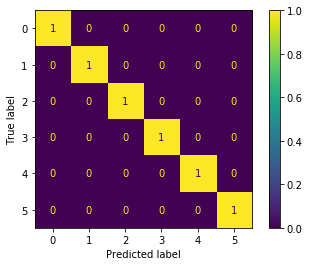

Reward sets:
{(0, 0): [-1, -1], (0, 1): [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, -1, -1, 0, 0, 0, -1, -1, 0, 0, 0, 0], (0, 2): [-1], (0, 3): [-3, -3], (0, 5): [-3], (0, 4): [-3, -3], (0, 6): [-4]}
Reward set counts:
Key (0, 0): 2 items
Key (0, 1): 40 items
Key (0, 2): 1 items
Key (0, 3): 2 items
Key (0, 5): 1 items
Key (0, 4): 2 items
Key (0, 6): 1 items


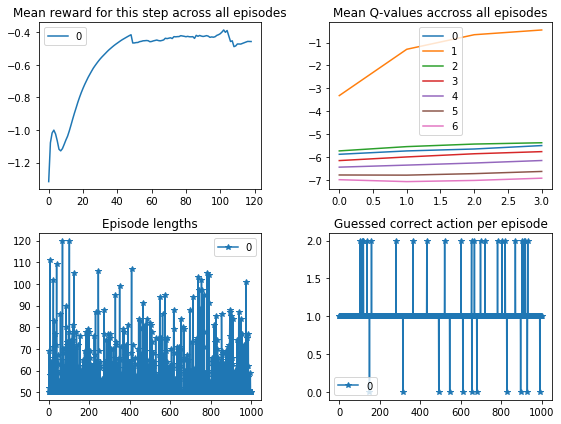

100%|██████████| 1000/1000 [00:01<00:00, 622.61it/s]


Accuracy: 96.1
Mean episode length: 56.648
Last reward processor:
Estimated confusion matrix:


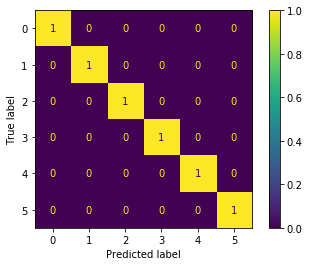

Reward sets:
{(0, 2): [-1], (0, 0): [-1], (0, 1): [0, -1, -1, 0, 0, 0, 0, -2, -1, -1, -1, -1, 0, 0, -2, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -2, 0, 0, 0, -1, 0, 0, -2, 0, 0, -2, 0, -2, -2, -1, -1], (0, 3): [-2], (0, 6): [-5, -4]}
Reward set counts:
Key (0, 2): 1 items
Key (0, 0): 1 items
Key (0, 1): 44 items
Key (0, 3): 1 items
Key (0, 6): 2 items


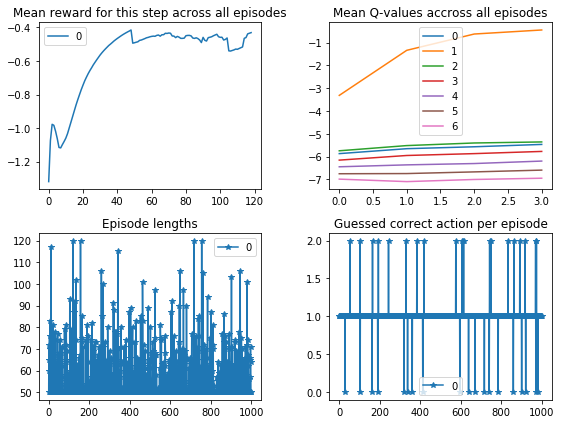

In [53]:
res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
params=res['params']

params['noise'] = True
params['surrogate'] = False
plot_mean_q_values(params=params)

params['surrogate'] = True
plot_mean_q_values(params=params)

# TODO

In [22]:
import numpy as np
from bayes_opt import BayesianOptimization
from pymoo.optimize import minimize
from pymoo.util import plotting
from pymoo.model.problem import Problem

max_steps = 120
num_episodes = 100

class QLearningProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=np.array([0, 0, 10]), xu=np.array([1, 1, 80]))
    
    def _evaluate(self, X, out, *args, **kwargs):
        alpha, epsilon, epsilon_decay = X

        # Run your Q-learning experiment with given parameters
        params = {'alpha': alpha, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay}
        q_values_all_experiments, _, episode_lengths, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)

        # Maximize accuracy
        out["F"] = [-accuracy, -np.mean(episode_lengths)]

problem = QLearningProblem()

algorithm = minimize(
    algorithm="nsga2",
    problem=problem,
    termination=("n_gen", 20),  # Adjust the number of generations as needed
    save_history=True,
    verbose=True,
)

# Get the best solution from the Pareto front
best_solution = algorithm.result[0]

best_alpha, best_epsilon, best_epsilon_decay = best_solution.X

print(f"Best alpha: {best_alpha}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best epsilon_decay: {best_epsilon_decay}")
print(f"Best accuracy: {-best_solution.F[0]}")
print(f"Best mean_episode_length: {-best_solution.F[1]}")

# You can visualize the Pareto front using pymoo's plotting functions
plotting.plot(obj_space=algorithm.result.F, ideal_point=np.array([0, 0]), title="Pareto Front")


ModuleNotFoundError: No module named 'pymoo'

# Profiling

In [ ]:
# !pip install line_profiler
%load_ext line_profiler

In [ ]:
#402088000.0
max_steps = 120
num_episodes = 2
%lprun -f qLearningExperiment qLearningExperiment(adjust_rewards_surrogate,params={'plots': False})

100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


Timer unit: 1e-09 s

Total time: 0.151271 s
File: /var/folders/hj/_04fr6wx5tncwlntq6ym_zr00000gn/T/ipykernel_5724/1818113075.py
Function: qLearningExperiment at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def qLearningExperiment(difference_fn=None, learner=None, params=default_params()):
     2         1       2000.0   2000.0      0.0      plots = params.get('plots', True)
     3                                           
     4         1          0.0      0.0      0.0      q_values_all_experiments = []
     5         1          0.0      0.0      0.0      rewards_all_experiments = []
     6         1          0.0      0.0      0.0      episode_lengths = []
     7         1          0.0      0.0      0.0      selected_actions = []
     8                                           
     9         3    3286000.0    1e+06      2.2      for i in tqdm(range(num_episodes)):
    10                                       

In [ ]:
# 97219000.0/413000.0 = 235
%lprun -f runner runner(adjust_rewards=adjust_rewards_surrogate, params={'plots': False})

Timer unit: 1e-09 s

Total time: 0.117403 s
File: /var/folders/hj/_04fr6wx5tncwlntq6ym_zr00000gn/T/ipykernel_5724/2161407780.py
Function: runner at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def runner(adjust_rewards=None, 
     2                                                      agent=None,
     3                                                      env=None,
     4                                                      params=default_params()):
     5                                           
     6         1      38000.0  38000.0      0.0      agent = agent if agent else UCBQAgent(num_actions=num_states)
     7         1       3000.0   3000.0      0.0      env = env if env else ModifiedRandomEnvironment()
     8                                           
     9         1          0.0      0.0      0.0      episode_rewards = 0
    10         1          0.0      0.0      0.0      rewards = []
    11        

# Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
from IPython import display
import pandas as pd

In [ ]:
max_steps = 120
num_episodes = 20

param_grid = {
    'alpha': [0, 1.0],
    # 'alpha_decay'
    # alpha_min
    'epsilon': [0, 1.0],
    # 'epsilon_decay': [0.1, 1.0],
    # 'gamma'
    'epsilon_decay': [10, 20, 40, 80],
    # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # 'surrogate_lr'
    }

param_grid_out = pd.DataFrame(ParameterGrid(param_grid))

def get_results_from_grid_row(params):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    mean_episode_length = np.mean(episode_lengths)
    print(accuracy, mean_episode_length) 

    return accuracy, mean_episode_length

for i, params in tqdm(param_grid_out.iterrows(), total=param_grid_out.shape[0]):
    accuracy, mean_episode_length = get_results_from_grid_row(params)
    param_grid_out.loc[i, 'accuracy'] = accuracy
    param_grid_out.loc[i, 'mean_episode_length'] = mean_episode_length
    # display.clear_output()

  6%|▋         | 1/16 [00:11<02:47, 11.14s/it]

0.0 121.0


  6%|▋         | 1/16 [00:22<05:40, 22.68s/it]


KeyboardInterrupt: 

In [ ]:
# param_grid_out.iloc[0]['accuracy'] = 1
print(param_grid_out.sort_values(by=['accuracy', 'mean_episode_length'], ascending=False))

    alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
1     0.1      0.1             20      95.0                73.70
7     0.1      1.0             80      90.0                82.70
15    1.0      1.0             80      85.0                91.00
4     0.1      1.0             10      85.0                83.35
10    1.0      0.1             40      85.0                78.55
5     0.1      1.0             20      85.0                75.75
12    1.0      1.0             10      80.0                80.90
6     0.1      1.0             40      75.0                78.45
11    1.0      0.1             80      75.0                78.45
14    1.0      1.0             40      75.0                77.20
8     1.0      0.1             10      75.0                74.95
2     0.1      0.1             40      70.0                87.90
13    1.0      1.0             20      70.0                82.85
3     0.1      0.1             80      65.0                82.65
0     0.1      0.1       

# Q-value of "true" level compared accross different reward techniques

In [ ]:
#TODO:
# What if we reset the state to the original one, every 10 steps, and that would be our episode?
# -> keep the q-values, reset the parameters epsilon, learning rate, etc.

# Epsilon test

In [ ]:
np.log10(20+1)

1.3222192947339193

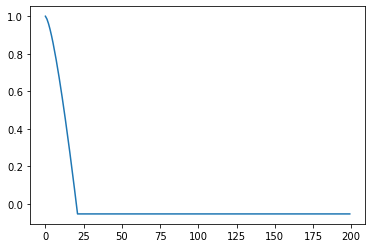

In [ ]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.epsilon)
    agent.choose_action(0)

plt.plot(epsilons)

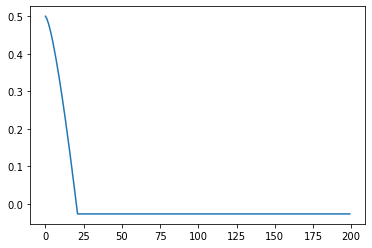

In [ ]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.alpha)
    agent.choose_action(0)

plt.plot(epsilons)

# Surrogate rewards without adding noise

In [ ]:
from modified_pendulum_processor_noiseless import ModifiedPendulumProcessorNoiseless

100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


Mean episode length: 61.0
Accuracy: 100.0
[[0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.8 0.  0.  0.  0.2 0. ]
 [0.  0.  0.8 0.  0.2 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.8 0.  0. ]
 [0.  0.2 0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.  0.  0.  0.8]]
{(0, 3): [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3], (0, 0): [-6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6], (0, 1): [-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5], (0, 2): [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4], (0, 4): [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], (0, 5): [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

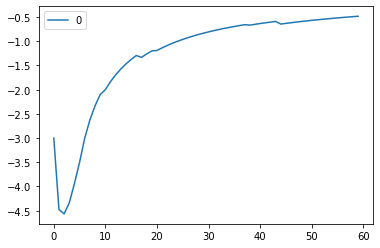

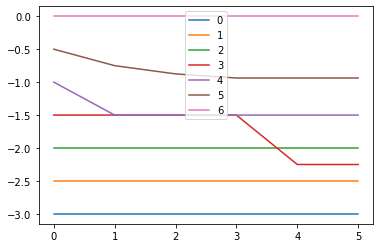

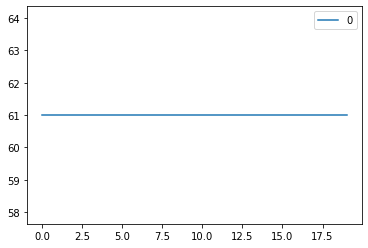

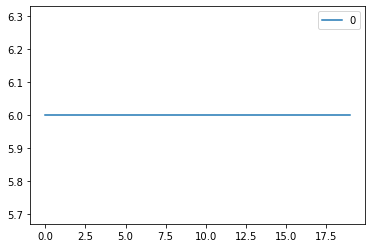

In [ ]:
post_processor_surrogate = ModifiedPendulumProcessorNoiseless()

def adjust_rewards_surrogate(reward, state, action):    
    observation, reward, done, info = post_processor_surrogate.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards_surrogate)

print(post_processor_surrogate.cmat)
print(post_processor_surrogate.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor_surrogate.C, decimals=4))